<a href="https://colab.research.google.com/github/Anu589/MNIST-Clustering-with-Autoencoder/blob/main/mnist_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MNIST Image Clustering and Outlier Detection
###Overview
This script performs clustering and outlier detection on the MNIST dataset using an autoencoder for dimensionality reduction. The key steps include:

- Load and preprocess MNIST dataset

- Train an autoencoder to extract a compressed representation of digits

- Extract latent features (16-dimensional compressed features from the encoder)

- Clustering on latent features

- K-Means (with elbow method to find optimal K)

- Hierarchical Clustering

- DBSCAN

- Outlier Detection using Local Outlier Factor (LOF)

- Reconstruct images using the autoencoder

- Evaluate clustering performance using metrics like ARI, NMI, and silhouette score

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from shapely.geometry import Polygon, LineString

###2. Load and Preprocess MNIST Dataset
- The MNIST dataset is loaded using tensorflow.keras.datasets.mnist.

- The images are normalized to the range [0, 1] by dividing by 255.

- The images are flattened from (28, 28) to (784,) for input into the autoencoder.

In [39]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [40]:
# Show original images
print("Original Images:")
for i in range(5):
    cv2_imshow(x_train[i])

Original Images:


Original Images:


In [4]:
# Show images after normalization
print("Images After Normalization:")
for i in range(5):
    cv2_imshow((x_train[i] * 255).astype(np.uint8))

Images After Normalization:


In [41]:
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0,1]

In [42]:
# Show images after normalization
print("Images After Normalization:")
for i in range(5):
    cv2_imshow((x_train[i] * 255).astype(np.uint8))

Images After Normalization:


Images After Normalization:


In [43]:
# Reshape for the neural network (Flattening images)
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

Q. Why normalize and flatten?

- Neural networks perform better with normalized inputs (values between 0 and 1).

- Fully connected layers require 1D inputs, so we flatten the images.

###3. Define and Train Autoencoder
The autoencoder consists of:

- Encoder: Reduces input size (28×28 = 784 pixels → 16 features)

- Decoder: Expands the 16 features back to 784 pixels (reconstruction)

- The model is trained using the Adam optimizer and Mean Squared Error (MSE) loss.

In [44]:
# Define Autoencoder
encoding_dim = 16  # Size of latent space(compressed representation of input)
input_img = Input(shape=(28*28,))
encoded = Dense(128, activation='relu')(input_img)  # using relu activation to reduce no. of neurons
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded) #compress input image to 16 values


In [45]:
# Decoding Process
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)  #expands the image
decoded = Dense(28*28, activation='sigmoid')(decoded)  # Output layer in 784 last layer has sigmoid as pixel values ranges from 0 to 1

In [46]:
autoencoder = Model(input_img, decoded) #input ->encoding -> decoding -> output
encoder = Model(input_img, encoded)  # Extract features using encoder

In [47]:
autoencoder.compile(optimizer='adam', loss='mse') #adam is the optimizer and MSE is used to see how well original and output match

In [48]:
# Train Autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_test, x_test), verbose=1)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.0977 - val_loss: 0.0381
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0348 - val_loss: 0.0274
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0268 - val_loss: 0.0239
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0239 - val_loss: 0.0221
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0222 - val_loss: 0.0209
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0202 - val_loss: 0.0192
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0184 - val_loss: 0.0177
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0178 - val_loss: 0.0169
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0170 - val_loss: 0.0164
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0944 - val_loss: 0.0371
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0348 - val_loss: 0.0278
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0267 - val_loss: 0.0230
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0228 - val_loss: 0.0213
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0210 - val_loss: 0.0196
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0196 - val_loss: 0.0184
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0185 - val_loss: 0.0176
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0177 - val_loss: 0.0170
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0172 - val_loss: 0.0165
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

- Input and output are the same because an autoencoder learns to reconstruct input.

- Mean Squared Error (MSE) is used to measure reconstruction quality.

###4. Extract Latent Features
- The encoder is used to extract 16-dimensional latent features from the test set.
- These encoded features will be used for clustering.

In [49]:
# Extract 16D latent features
encoded_imgs = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [50]:
# Show encoded images (compressed representation - not directly viewable, but can be printed)
print("Encoded representations (first 5 samples):")
print(encoded_imgs[:5])

Encoded representations (first 5 samples):
[[ 2.5071278   6.094017    8.35943     7.103001   15.09064    13.043908
  10.426936   15.402974   13.704944   10.167751   11.514642   11.935207
   0.          5.853599   17.025415   10.666242  ]
 [35.63592    13.597101   15.628331   18.123934   13.730311   20.078169
  20.727285   18.858217   15.44987    13.509576   20.461493   24.836983
   0.         15.252183    5.1282864   8.546494  ]
 [18.009237    0.87048024  2.410397   10.172847   11.751614   21.45062
  16.447582    6.3471036   8.523075   12.44475    10.763911   25.326395
   0.          7.5511346  11.821076    4.1988916 ]
 [23.637455   21.348598   15.112781    9.120351   20.586449   20.951714
  10.307191   24.491205   20.732111   14.326976   21.230556   20.676048
   0.          8.091267   12.91866    18.113913  ]
 [13.351246   16.38218     5.809641    8.556556    9.026195   16.354132
  11.788438   21.185894   17.429134    6.7998767   2.5399973   7.774487
   0.         11.446301   13.86008

###5.  Clustering
####5.1 Elbow Method for Optimal K
- The elbow method is used to determine the optimal number of clusters (K) for K-Means.

- The second derivative of the distortion (inertia) is computed to find the elbow point.

In [51]:
def plot_elbow_method(data, max_k=15):
    distortions = []
    K_range = range(1, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Compute the second derivative to find the elbow point
    diff = np.diff(distortions)  # First derivative
    diff2 = np.diff(diff)  # Second derivative
    elbow = np.argmin(diff2) + 2  # +2 because diff2 shifts indices twice

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, distortions, 'bo-', label="Distortion")
    plt.axvline(x=elbow, color='r', linestyle='--', label=f"Elbow at K={elbow}")
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')
    plt.legend()
    plt.show()

    print(f"Optimal number of clusters (Elbow Point) is: {elbow}")
    return elbow

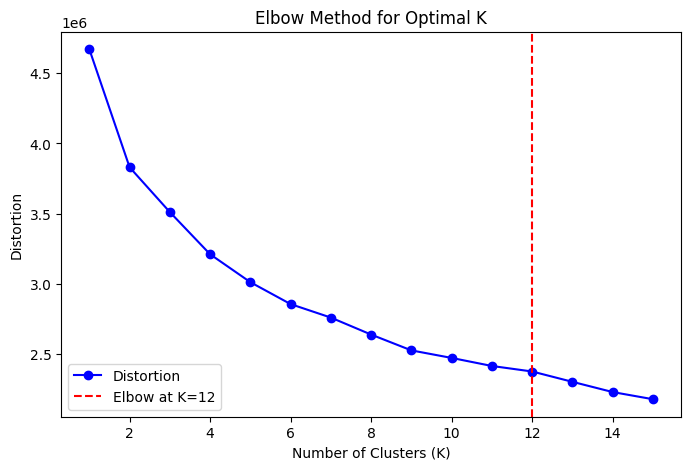

Optimal number of clusters (Elbow Point) is: 12


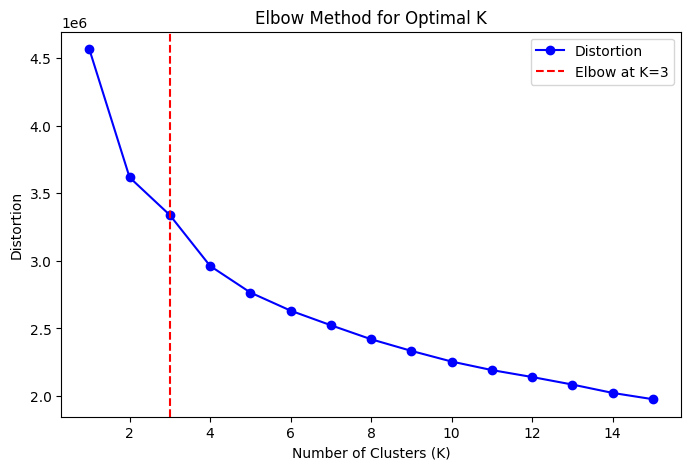

Optimal number of clusters (Elbow Point) is: 3


In [52]:
# Run Elbow Method on Encoded Images
optimal_k= plot_elbow_method(encoded_imgs, max_k=15)

####5.2 K-Means Clustering
K-Means is applied to the latent features using the optimal K determined by the elbow method.

In [53]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_imgs)
cluster_centers = kmeans.cluster_centers_

In [54]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded_imgs)
pca_centers = pca.transform(cluster_centers)

In [55]:
# Color Voronoi regions based on clusters
import matplotlib.colors as mcolors

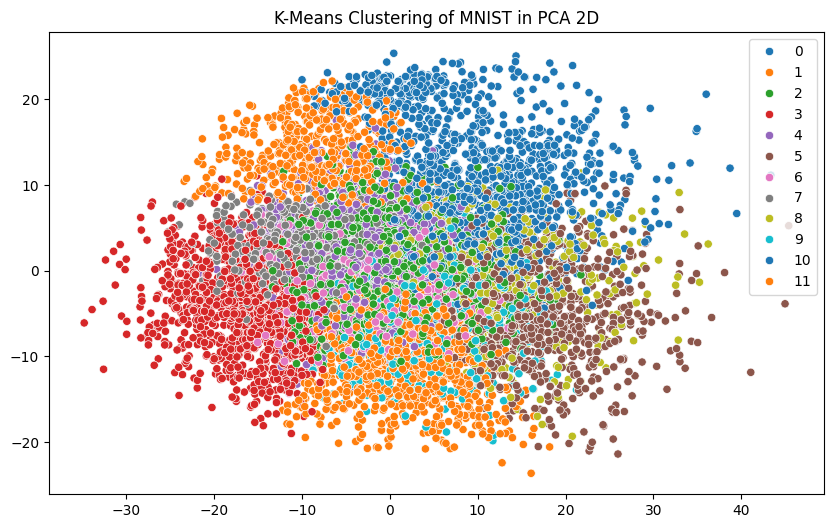

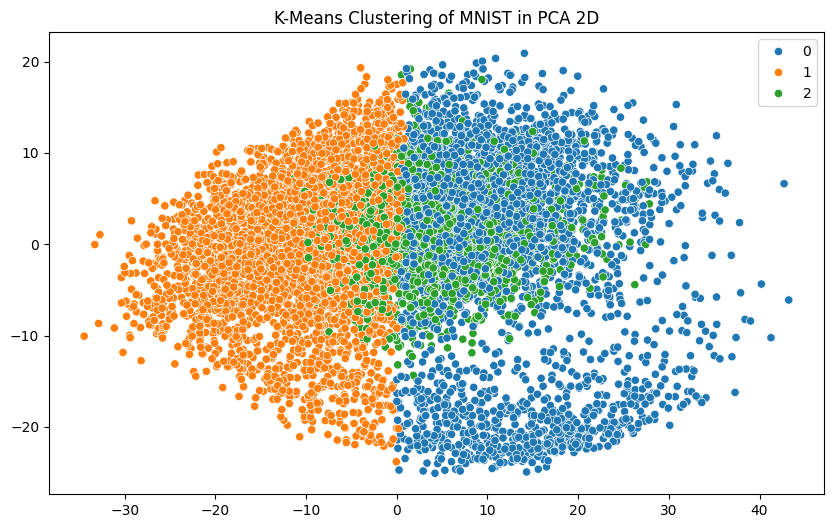

In [56]:
# Plot Clustering with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("K-Means Clustering of MNIST in PCA 2D")
plt.show()

In [57]:
# Apply K-Means on the original encoded images (not PCA-transformed)
optimal_k = 10  # Define optimal_k if not set earlier
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_imgs)  # Use full-dimensional encoded_imgs
cluster_centers = kmeans.cluster_centers_  # Get cluster centers in original space


In [58]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded_imgs)  # Reduce data to 2D
pca_centers = pca.transform(cluster_centers)  # Transform cluster centers to 2D



In [59]:
def plot_decision_boundaries(clusterer, X_pca, cluster_centers_pca, resolution=1000, show_centroids=True, optimal_k=None):
    # Define the grid
    mins = X_pca.min(axis=0) - 0.1
    maxs = X_pca.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))

    # **Fix: Predict using KMeans in full space, then transform to PCA space**
    Z_full_space = clusterer.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z_full_space.reshape(xx.shape)

    # Plot the decision boundaries
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="Pastel2")
    plt.contour(xx, yy, Z, linewidths=1, colors='k')

    # Plot the data points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusterer.labels_, cmap='viridis', s=10, alpha=0.8)

    # Plot the centroids
    if show_centroids:
        plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
                    marker='o', s=100, linewidths=2, facecolor='white', edgecolor='black', zorder=10)

    # Handle optimal_k in title
    if optimal_k is not None:
        plt.title(f"K-Means Voronoi Diagram (Optimal K={optimal_k})")
    else:
        plt.title("K-Means Voronoi Diagram")

    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.show()

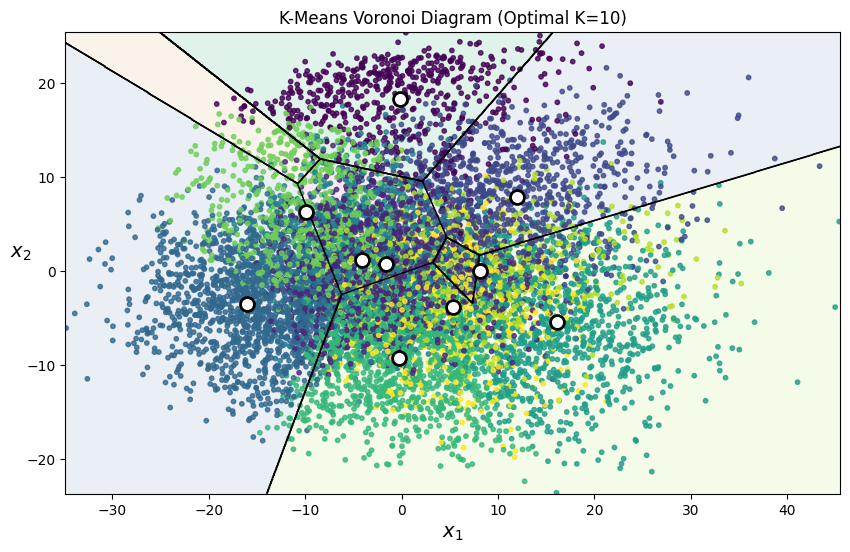

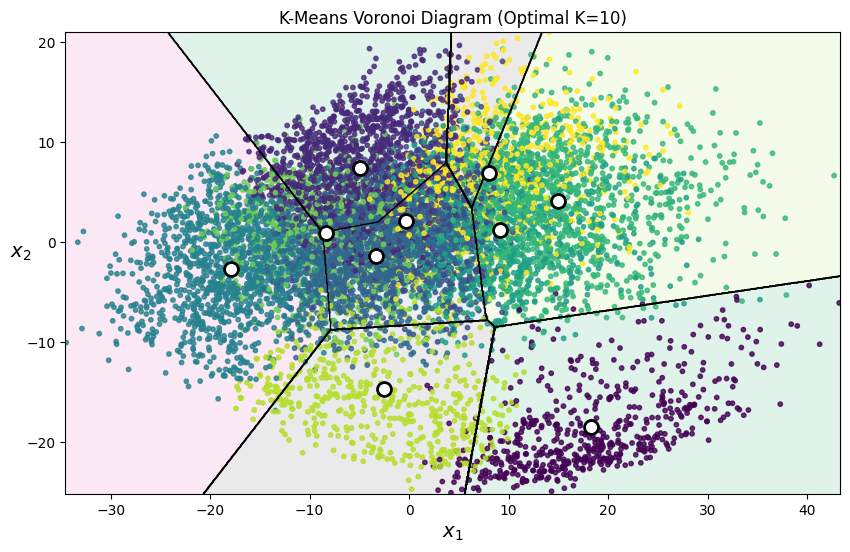

In [60]:
#  **Pass PCA-transformed data and centroids**
plt.figure(figsize=(10, 6))
plot_decision_boundaries(kmeans, encoded_pca, pca_centers, optimal_k=optimal_k)

####5..3 Hierarchical Clustering
Agglomerative Clustering is applied to the latent features.

In [61]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = hierarchical.fit_predict(encoded_imgs)

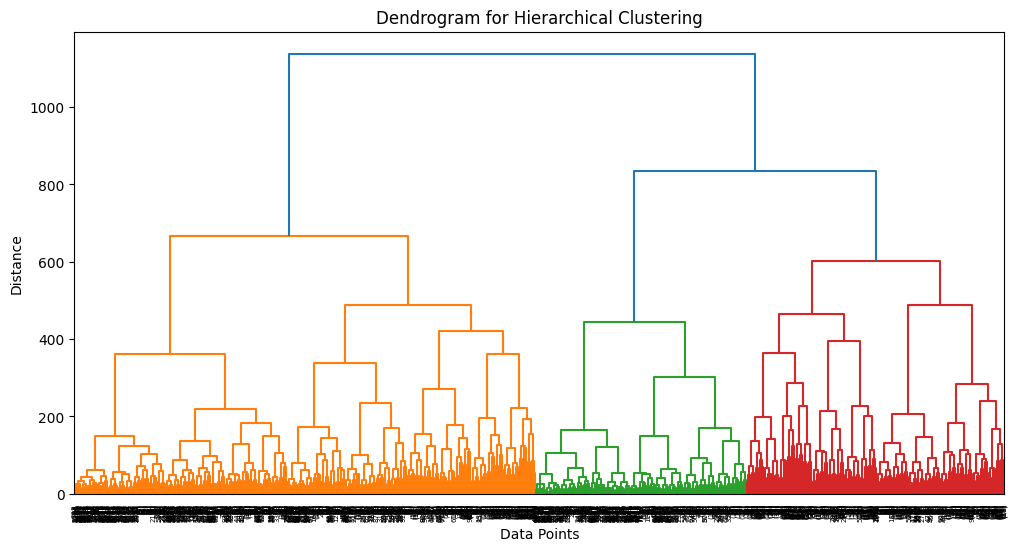

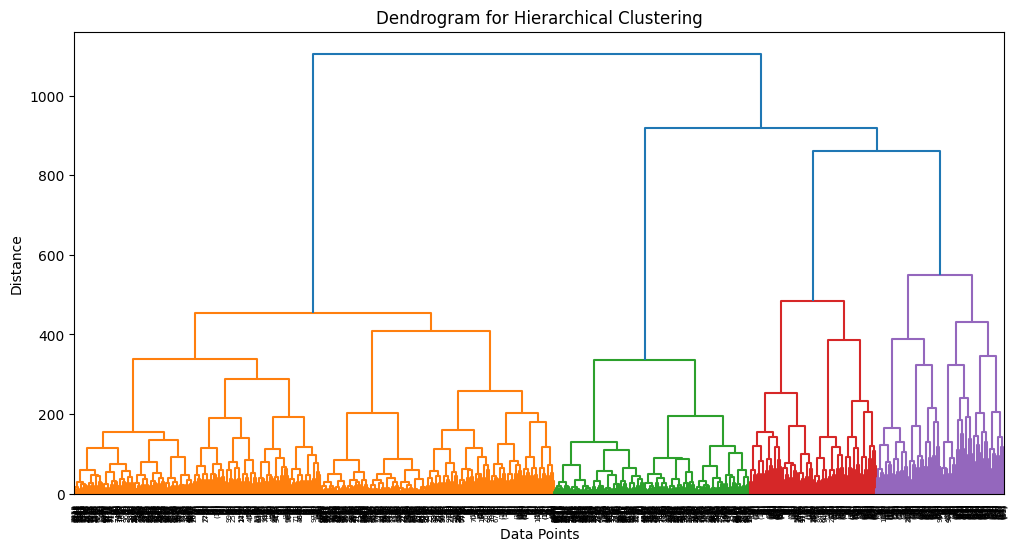

In [62]:
# Dendrogram for Hierarchical Clustering
linkage_matrix = linkage(encoded_imgs, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

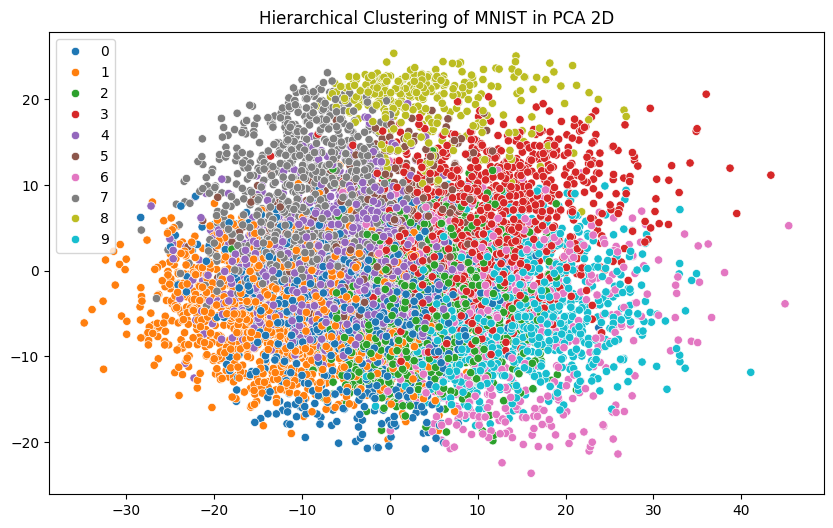

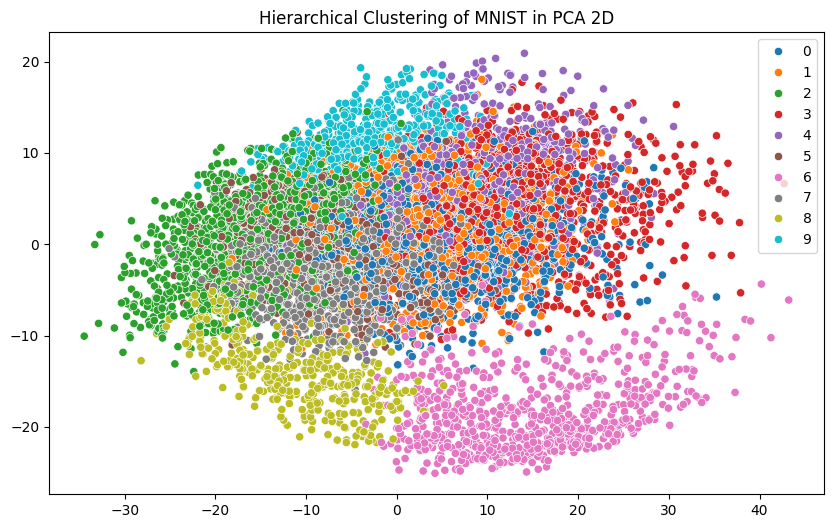

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=hierarchical_labels, palette='tab10')
plt.title("Hierarchical Clustering of MNIST in PCA 2D")
plt.show()

####5.4 DBSCAN Clustering
DBSCAN is applied to the latent features.

In [64]:
# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(encoded_imgs)

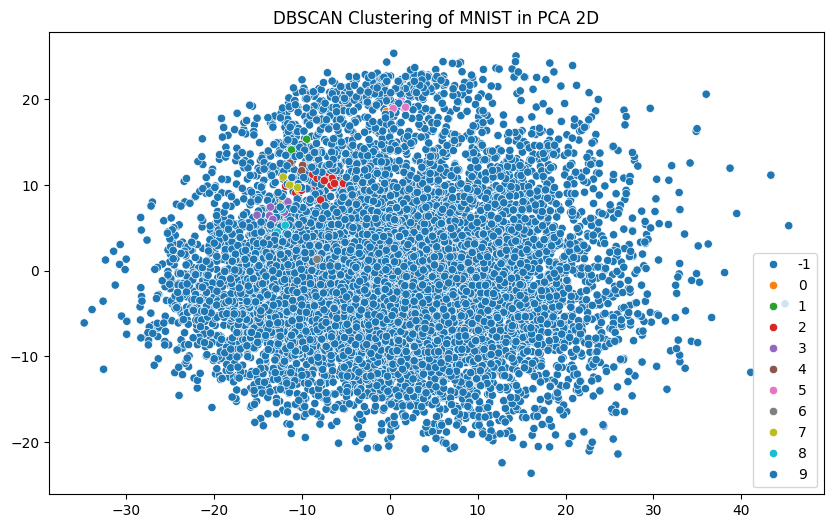

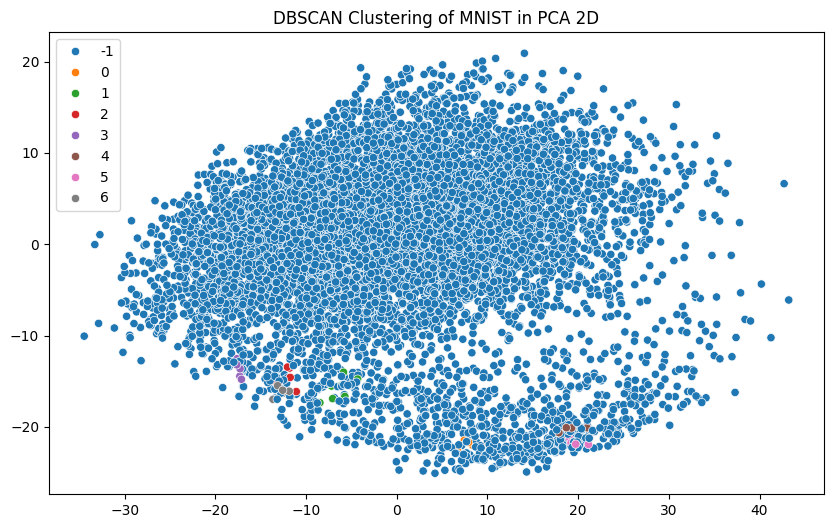

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=dbscan_labels, palette='tab10')
plt.title("DBSCAN Clustering of MNIST in PCA 2D")
plt.show()

###6. Outlier Detection
Local Outlier Factor (LOF) is used to detect outliers in the latent space.

In [66]:
# Outlier Detection using Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20)
outlier_scores = lof.fit_predict(encoded_imgs)
outlier_indices = np.where(outlier_scores == -1)[0]

Number of outliers detected: 18


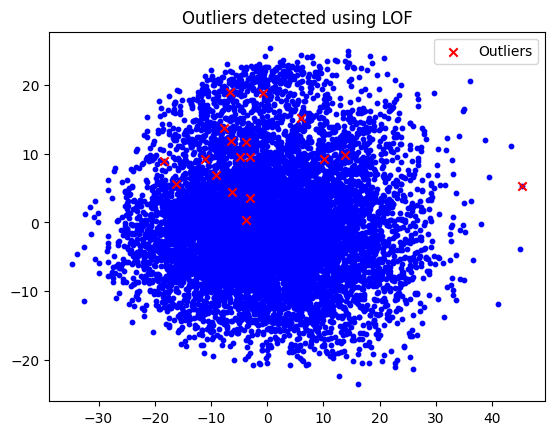

Number of outliers detected: 21


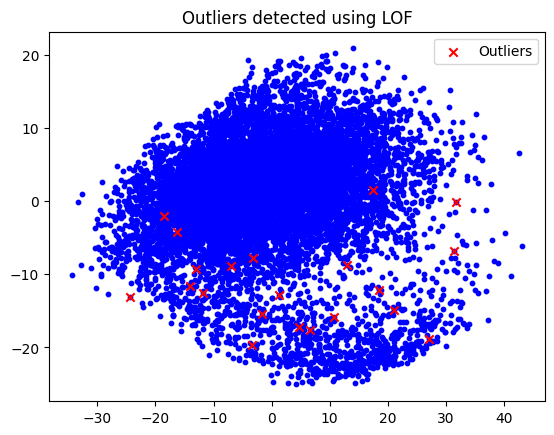

In [67]:
print(f"Number of outliers detected: {len(outlier_indices)}")
plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1], c='blue', s=10)
plt.scatter(encoded_pca[outlier_indices, 0], encoded_pca[outlier_indices, 1], c='red', marker='x', label='Outliers')
plt.legend()
plt.title("Outliers detected using LOF")
plt.show()


###7. Image Reconstruction
The autoencoder is used to reconstruct images from the test set.

Original and reconstructed images are displayed side by side.

In [68]:
def show_images(original, reconstructed, num_images=5):
    for i in range(num_images):
        orig = (original[i].reshape(28, 28) * 255).astype(np.uint8)
        recon = (reconstructed[i].reshape(28, 28) * 255).astype(np.uint8)

        print(f"Original Image {i}:")
        cv2_imshow(orig)
        print(f"Reconstructed Image {i}:")
        cv2_imshow(recon)

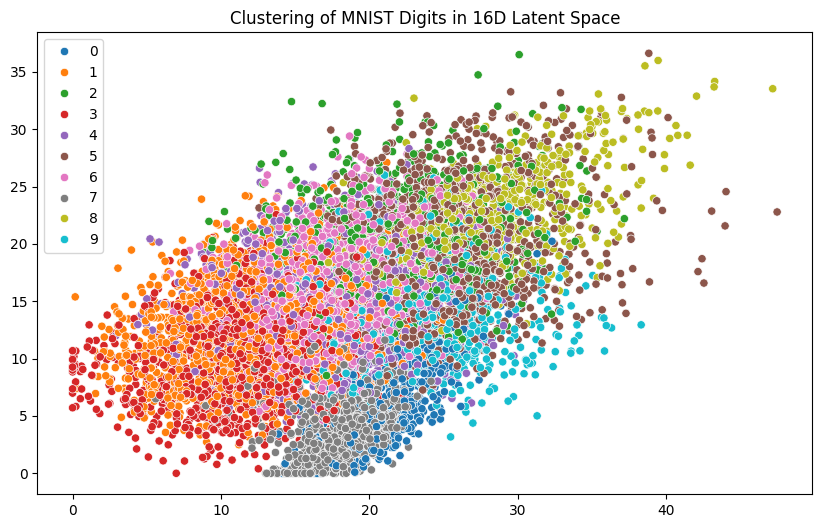

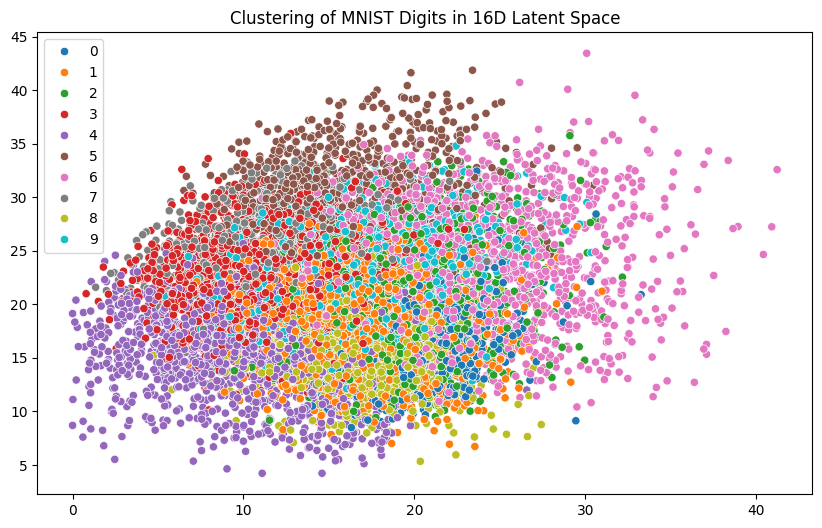

In [69]:
# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_imgs[:, 0], y=encoded_imgs[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("Clustering of MNIST Digits in 16D Latent Space")
plt.show()

In [70]:
def show_images(original, reconstructed, num_images=5):
    for i in range(num_images):
        orig = (original[i].reshape(28, 28) * 255).astype(np.uint8)
        recon = (reconstructed[i].reshape(28, 28) * 255).astype(np.uint8)

        print(f"Original Image {i}:")
        cv2_imshow(orig)
        print(f"Reconstructed Image {i}:")
        cv2_imshow(recon)

In [71]:
# Reconstruct images from the autoencoder
reconstructed_imgs = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [72]:
# Show reconstructed images
print("Reconstructed Images:")
show_images(x_test, reconstructed_imgs)

Reconstructed Images:
Original Image 0:


Reconstructed Image 0:


Original Image 1:


Reconstructed Image 1:


Original Image 2:


Reconstructed Image 2:


Original Image 3:


Reconstructed Image 3:


Original Image 4:


Reconstructed Image 4:


Reconstructed Images:
Original Image 0:


Reconstructed Image 0:


Original Image 1:


Reconstructed Image 1:


Original Image 2:


Reconstructed Image 2:


Original Image 3:


Reconstructed Image 3:


Original Image 4:


Reconstructed Image 4:


In [73]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Compute ARI and NMI (for K-Means)
ari_kmeans = adjusted_rand_score(y_test, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y_test, kmeans_labels)
silhouette_kmeans = silhouette_score(encoded_imgs, kmeans_labels)

print(f"K-Means Clustering Evaluation:")
print(f"Adjusted Rand Index (ARI): {ari_kmeans:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_kmeans:.4f}")
print(f"Silhouette Score: {silhouette_kmeans:.4f}")


K-Means Clustering Evaluation:
Adjusted Rand Index (ARI): 0.2195
Normalized Mutual Information (NMI): 0.3769
Silhouette Score: 0.1332
K-Means Clustering Evaluation:
Adjusted Rand Index (ARI): 0.2499
Normalized Mutual Information (NMI): 0.4020
Silhouette Score: 0.1395
